In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from tqdm import tqdm
import seaborn as sns

from Bayesian import BayesianLinearRegression

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [4]:
milk_data_OG = pd.read_csv('../Data/TheData.csv')
milk_data_OG['DateTime'] = pd.to_datetime(milk_data_OG['DateTime'], errors='coerce')
milk_data_OG['StartTime'] = pd.to_datetime(milk_data_OG['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
milk_data_OG['StartDate'] = pd.to_datetime(milk_data_OG['StartDate'], errors='coerce')

In [5]:
# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'SE_Number' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('SE_Number')):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Calculate the daily yield change and normalize it
            
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    
    return dataset


### Calculate daily records and normalize by Wood's Lactation Cycle

In [6]:
DATA = milk_data_OG.copy()

agg_functions = {
        'FarmName_Pseudo': 'first',
        'TotalYield': 'sum', # Daily sum of all the yields. Can be replaced with 'mean' to get daily mean instead
        'HW': 'first', # Since the HW indicator will be the same for all instances of the same day (given the same farm), we save the 'first'
        'cum_HW': 'first', # Same as for 'HW'
        'DaysInMilk': 'first', # Same as for 'HW'
        'LactationNumber': 'first', # Same as for 'HW'
        'Temperature': ['mean', 'max', 'min'], #Save both the daily Max temperature as well as daily mean temperature
        'Relative Humidity': 'mean', # Save daily mean humidity
        'THI_adj': 'mean' # save daily mean THI-adjusted
    }

breed_dummies = pd.get_dummies(DATA['BreedName'], prefix='Breed').astype(int)
breed_agg_functions = {breed: 'first' for breed in list(breed_dummies.columns)}
DATA = pd.get_dummies(DATA, columns=['BreedName'], prefix='Breed', dtype=int)

agg_functions = {**agg_functions, **breed_agg_functions}
daily_DATA = DATA.groupby(['SE_Number', 'StartDate']).agg(agg_functions).reset_index() #Group by day (StartDate)

# Remove the weird 'first' prefixes from the column names
daily_DATA.columns = [' '.join(col).strip() if 'first' not in col[1] else col[0] for col in daily_DATA.columns.values] 

# rename the columns to approiate prefixes
daily_DATA = daily_DATA.rename(columns={
    'TotalYield sum': 'DailyTotalYield',
    'DaysInMilk first': 'DaysInMilk',
    'Temperature mean': 'MeanTemperature',
    'Temperature max': 'MaxTemperature',
    'Temperature min': 'MinTemperature',
    'Relative Humidity mean': 'MeanRelHumidity',
    'THI_adj mean': 'MeanTHI_adj'
})
daily_data = fit_woods_lactation_curve(daily_DATA)
daily_data.head()

  1%|          | 2/376 [00:00<00:21, 17.71it/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 99%|█████████▊| 371/376 [00:12<00:00, 29.63it/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 376/376 [00:12<00:00, 30.39it/s]


,SE_Number,StartDate,FarmName_Pseudo,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras,ExpectedYield,NormalizedDailyTotalYield
0,SE-064c0cec-1189,2022-01-01,a624fb9a,30.77,0,0.0,191.0,7,-3.150000,-2.3,-4.0,92.900000,-1587.361000,0,1,0,0,0,29.739372,1.034655
1,SE-064c0cec-1189,2022-01-02,a624fb9a,48.22,0,0.0,192.0,7,-0.500000,0.3,-2.1,99.033333,-1428.221600,0,1,0,0,0,29.692059,1.624003
2,SE-064c0cec-1189,2022-01-03,a624fb9a,30.53,0,0.0,193.0,7,2.600000,2.9,2.3,97.300000,-1098.689840,0,1,0,0,0,29.644756,1.029862
3,SE-064c0cec-1189,2022-01-04,a624fb9a,42.26,0,0.0,194.0,7,-0.466667,-0.1,-1.1,93.300000,-1339.335013,0,1,0,0,0,29.597463,1.427825
4,SE-064c0cec-1189,2022-01-05,a624fb9a,38.49,0,0.0,195.0,7,-3.900000,-0.9,-5.9,87.133333,-1533.761680,0,1,0,0,0,29.550181,1.302530


In [10]:
subject_type = 'cow'  # Adjust here to 'farm' if needed
cow_id = 'SE-a624fb9a-1261' #Adjust here for specific cow
farm_id = 'f454e660' #adjust here for specific farm
subject_id =  cow_id if subject_type == 'cow' else farm_id


data = daily_data[daily_data['SE_Number' if subject_type == 'cow' else 'FarmName_Pseudo'] == subject_id].copy()

print(f"The daily records dataframe for {subject_id} ({subject_type}) has {data.shape[0]} entries and {data.shape[1]} columns")
data.head(3)

The daily records dataframe for SE-a624fb9a-1261 (cow) has 622 entries and 20 columns


,SE_Number,StartDate,FarmName_Pseudo,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras,ExpectedYield,NormalizedDailyTotalYield
12119,SE-a624fb9a-1261,2022-01-09,a624fb9a,19.82,0,0.0,2.0,4,-1.866667,-1.2,-2.3,98.166667,-1550.872840,0,1,0,0,0,24.480502,0.809624
12120,SE-a624fb9a-1261,2022-01-10,a624fb9a,22.13,0,0.0,3.0,4,-3.233333,-2.6,-3.7,93.300000,-1598.255733,0,1,0,0,0,27.876096,0.793870
12121,SE-a624fb9a-1261,2022-01-11,a624fb9a,29.47,0,0.0,4.0,4,-2.325000,-1.3,-3.6,95.950000,-1562.214280,0,1,0,0,0,30.512187,0.965844


In [14]:
selected_feats = ['HW','cum_HW', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] #+ list(breed_dummies.columns)
BM = BayesianLinearRegression(daily_data,
                              subject_name=subject_id,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = subject_type)
results = BM.fit_model()


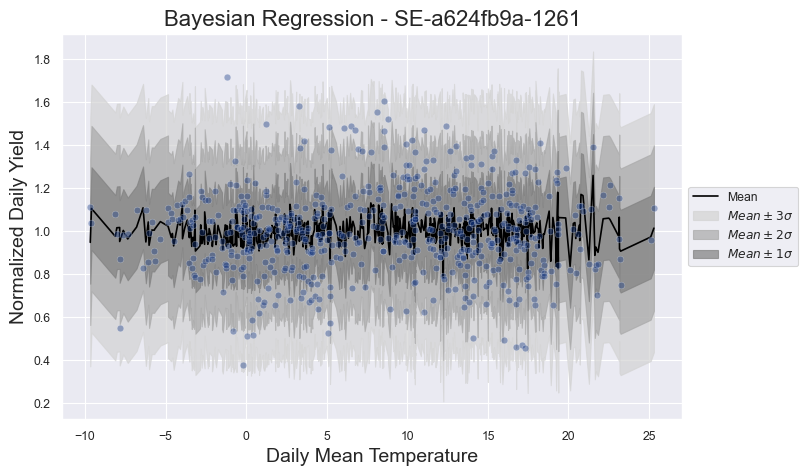

In [17]:
fig = BM.plot_model_uncertainty(ordered_by = 'MeanTemperature')

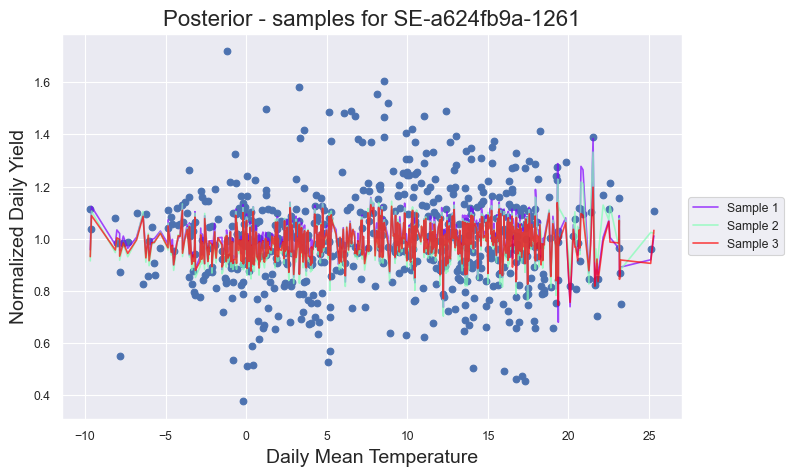

In [18]:
fig = BM.plot_model_samples(ordered_by='MeanTemperature',n_samples=3)

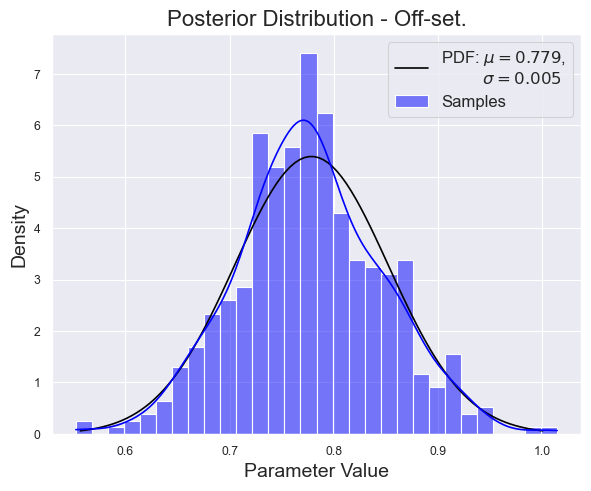

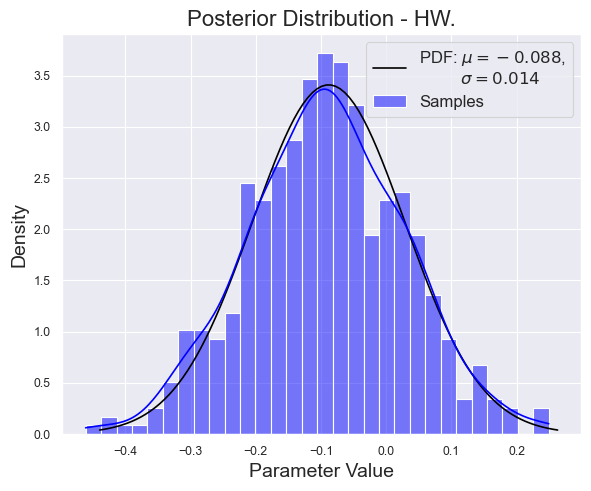

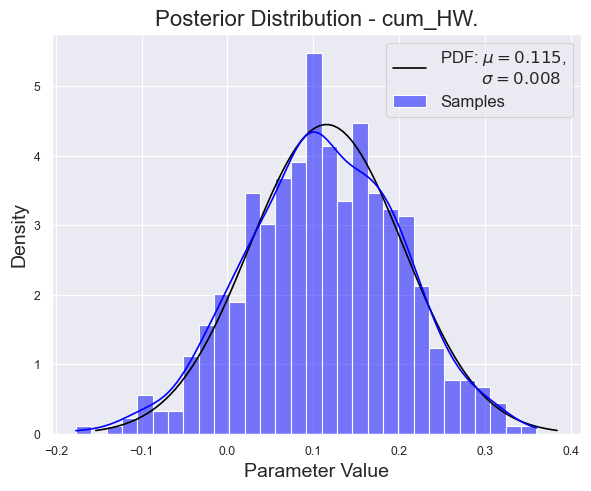

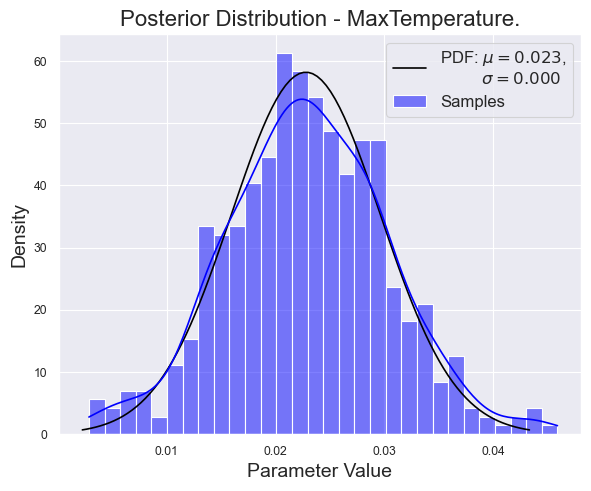

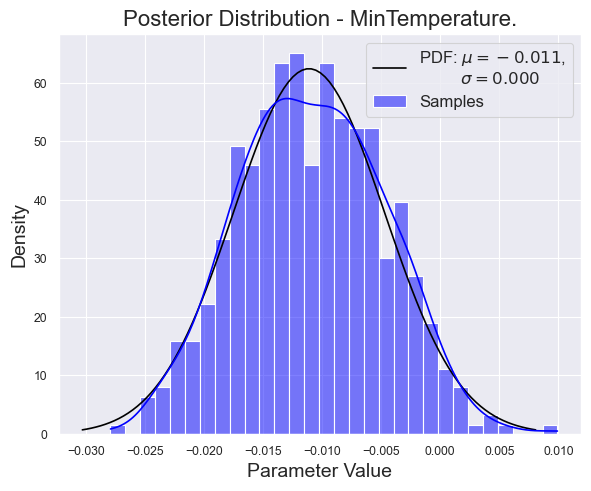

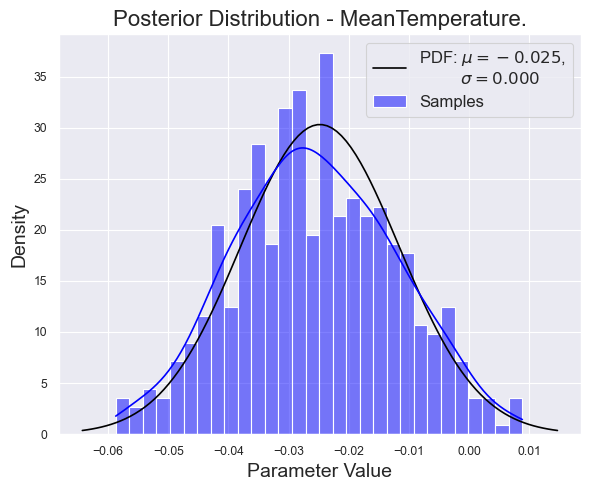

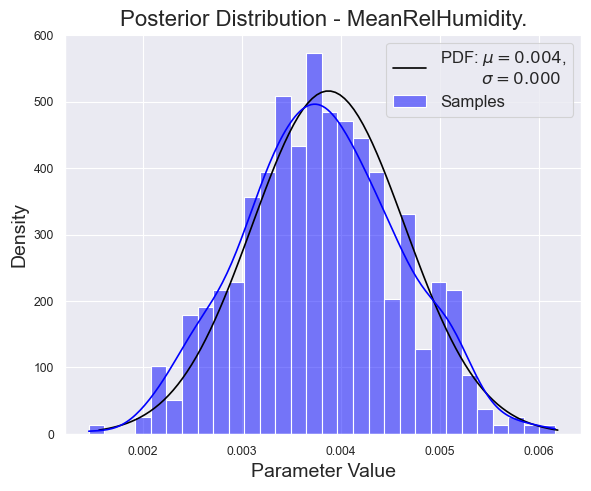

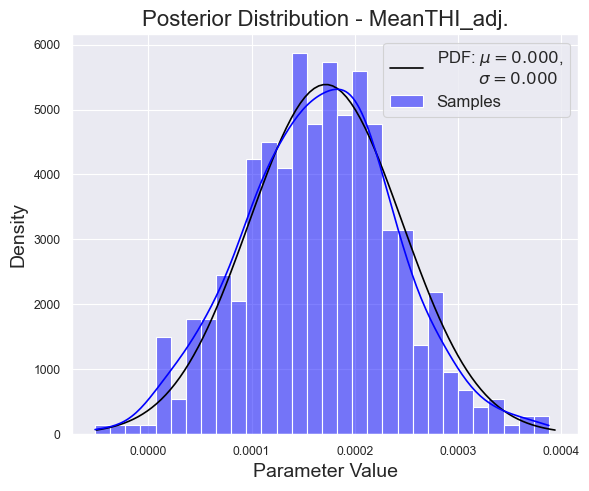

In [19]:
figs = BM.plot_posterior_distributions()

### Apply one model for each cow on one farm

In [21]:
farm = 'f454e660' #Choose a farm
daily_farm_data = daily_data[daily_data['FarmName_Pseudo'] == farm].copy() #Get the daily data for that farm
cows_list = list(daily_farm_data['SE_Number'].unique()) #list of all the cows at farm 'farm'

all_cows_result = {} #'dict to save posterior results
for cow in tqdm(cows_list, unit=' Cows'):
    daily_cow_data = daily_farm_data[daily_farm_data['SE_Number'] == cow] #get the cow specific data
    if daily_cow_data.empty: #if it is empty because of some reason, skip it
        continue
    selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
    BM = BayesianLinearRegression(daily_cow_data,
                              subject_name=cow,
                              selected_features = selected_feats,
                              target = ['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = 'cow')
    
    all_cows_result[cow] = BM.fit_model()

result_df = pd.DataFrame(all_cows_result).transpose() #make a dataframe of results
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
# Fit one model to the entire farm as well
BM = BayesianLinearRegression(daily_farm_data,
                              subject_name=farm,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = None)

farm_result = BM.fit_model()
breed_posterior = {}
for breed in list(breed_dummies.columns):
    breed_posterior[breed] = farm_result[breed]

result_df.index.name = 'SE_Number'
result_df.reset_index(inplace=True)
result_df.head(1)

 98%|█████████▊| 215/220 [00:03<00:00, 76.58 Cows/s]c:\Users\axele\OneDrive\Documents\HeatStressEvaluation\Modeling\Bayesian.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  self.beta = 1 / np.var(self.y + 1e-6)
c:\Users\axele\OneDrive\Documents\HeatStressEvaluation\Modeling\Bayesian.py:214: RuntimeWarning: invalid value encountered in multiply
  np.linalg.inv(self.prior_cov) + self.beta * self.Phi.T @ self.Phi
c:\Users\axele\OneDrive\Documents\HeatStressEvaluation\Modeling\Bayesian.py:214: RuntimeWarning: invalid value encountered in matmul
  np.linalg.inv(self.prior_cov) + self.beta * self.Phi.T @ self.Phi
c:\Users\axele\OneDrive\Documents\HeatStressEvaluation\Modeling\Bayesian.py:219: RuntimeWarning: invalid value encountered in multiply
  + self.beta * self.Phi.T @ self.y_reshaped
100%|██████████| 220/220 [00:03<00:00, 57.38 Cows/s]


,SE_Number,Off-set,HW,cum_HW,DaysInMilk,LactationNumber,MaxTemperature,MinTemperature,MeanTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras
0,SE-7fd04cd3-679,"{'mu': 1.4237621087372782e-05, 'sigma': 0.9999...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.005745304874240631, 'sigma': 0.031466...","{'mu': 5.6989646472202504e-05, 'sigma': 0.9999...","{'mu': -0.00020691297845698564, 'sigma': 0.994...","{'mu': -0.0002069129789478985, 'sigma': 0.9941...","{'mu': -0.0002069129771289091, 'sigma': 0.9941...","{'mu': -0.002907147776664898, 'sigma': 0.18426...","{'mu': 0.0007338885552722607, 'sigma': 0.02216...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}","{'mu': 1.4246751106838929e-05, 'sigma': 0.9999...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}"


In [32]:
for key, value in breed_posterior.items():
    print(f"{key} \n \mu = {value['mu']} \sigma {value['sigma']}")
    print()


Breed_01 SRB 
 \mu = 0.13602280055056326 \sigma 0.40825847739819865

Breed_02 SLB 
 \mu = 0.1336582104995614 \sigma 0.4082558939411307

Breed_04 SJB 
 \mu = 0.14174326082866173 \sigma 0.4082574332027465

Breed_41 Fjällko 
 \mu = 0.11324163363315165 \sigma 0.4083151650971137

Breed_99 Korsning/obestämbar ras 
 \mu = 0.1391442874155473 \sigma 0.4082567881149029



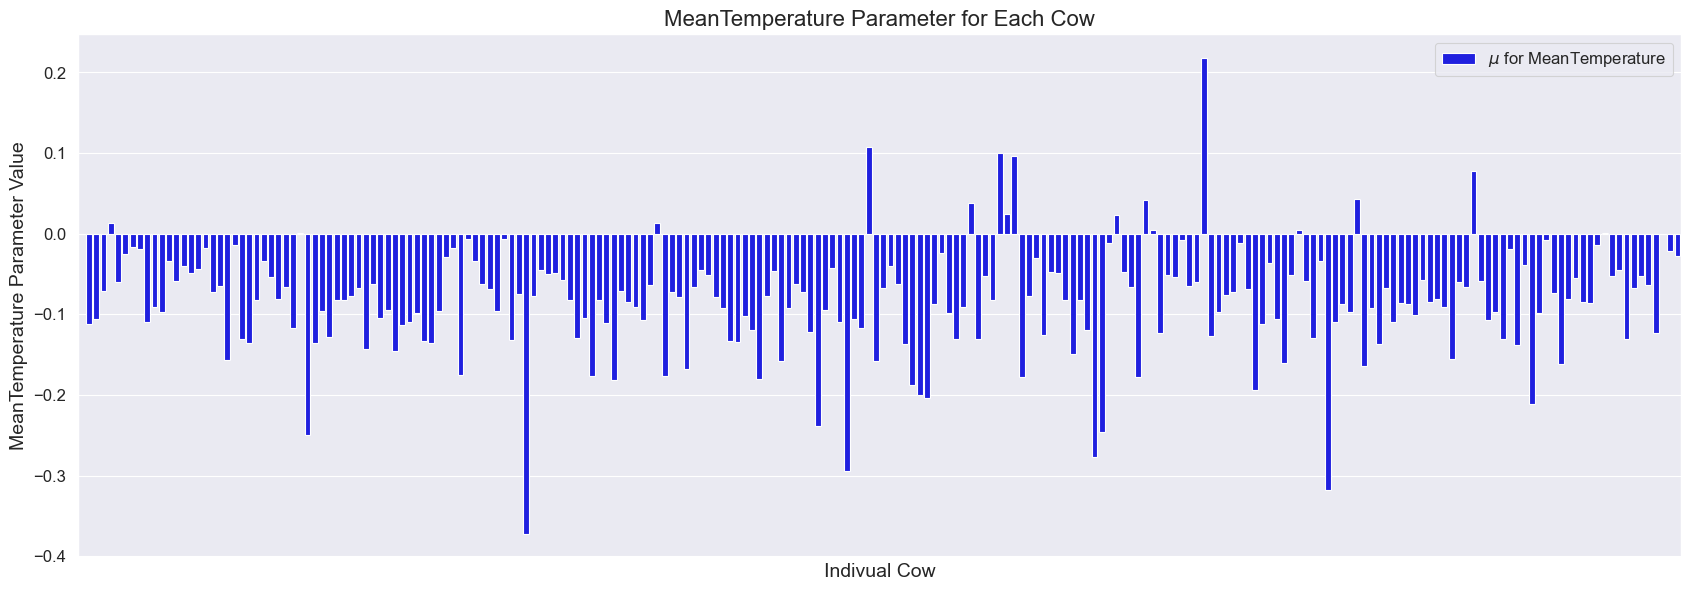

In [51]:
selected_parameter = 'MeanTemperature'
mu_values1 = result_df[selected_parameter].apply(lambda x: x['mu'])

plt.figure(figsize=(17, 6))
sns.barplot(x=mu_values1.index, y=mu_values1, color='blue', label=f"$\mu$ for {selected_parameter}")
plt.xlabel('Indivual Cow', fontsize=14)
plt.ylabel(f'{selected_parameter} Parameter Value', fontsize=14)
plt.title(f'{selected_parameter} Parameter for Each Cow', fontsize=16)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


## Compare 2 farms

In [42]:
farm2 = 'f454e660' # <--------- Adjust here  
daily_farm_data2 = daily_data[daily_data['FarmName_Pseudo'] == farm2].copy()
print(f"The daily records dataframe for cow {farm2} has {daily_farm_data2.shape[0]} entries and {daily_farm_data2.shape[1]} columns")

farm1 = 'a624fb9a' # <--------- Adjust here  
daily_farm_data1 = daily_data[daily_data['FarmName_Pseudo'] == farm1].copy()
print(f"The daily records dataframe for cow {farm1} has {daily_farm_data1.shape[0]} entries and {daily_farm_data1.shape[1]} columns")


The daily records dataframe for cow f454e660 has 84007 entries and 20 columns
The daily records dataframe for cow a624fb9a has 60495 entries and 20 columns


In [46]:
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
BM1 = BayesianLinearRegression(daily_farm_data1,
                              subject_name=farm1,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = False,
                              subject_type = 'Farm')

farm_result1 = BM1.fit_model()
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
BM2 = BayesianLinearRegression(daily_farm_data2,
                              subject_name=farm2,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = False,
                              subject_type = 'Farm')

farm_result2 = BM2.fit_model()

df1 = pd.DataFrame(farm_result1).transpose().reset_index()
df2 = pd.DataFrame(farm_result2).transpose().reset_index()

df1['Farm'] = 'Farm 1'
df2['Farm'] = 'Farm 2'
df1_breeds = df1[df1['index'].str.startswith('Breed')]
df1 = df1[~df1['index'].str.startswith('Breed')]

df2_breeds = df2[df2['index'].str.startswith('Breed')]
df2 = df2[~df2['index'].str.startswith('Breed')]



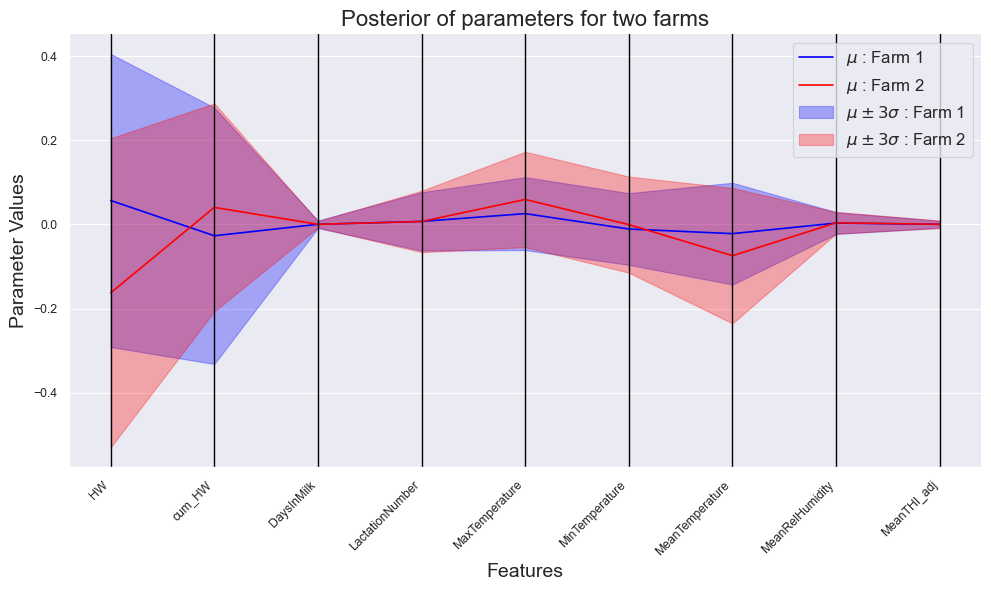

In [47]:

plt.figure(figsize=(10, 6))
sns.lineplot(x='index', y='mu', data=df1, dashes=False, markers='o', label='$\mu$ : Farm 1', color='blue')
sns.lineplot(x='index', y='mu', data=df2, dashes=False, markers='o', label='$\mu$ : Farm 2', color='red')
plt.fill_between(df1['index'], df1['mu'] - 3*np.sqrt(df1['sigma']), df1['mu'] + 3*np.sqrt(df1['sigma']),
                 alpha=0.3, label='$\mu \pm 3 \sigma$ : Farm 1', color='blue')
plt.fill_between(df2['index'], df2['mu'] - 3*np.sqrt(df2['sigma']), df2['mu'] + 3*np.sqrt(df2['sigma']),
                 alpha=0.3, label='$\mu \pm 3 \sigma$ : Farm 2', color='red')

plt.xticks(rotation=45, ha='right')
plt.title('Posterior of parameters for two farms', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Parameter Values', fontsize=14)
plt.legend()
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
sns.despine()

for tick in plt.xticks()[0]:
    plt.axvline(tick, color='black', linestyle='-', linewidth=1)

plt.show()

In [50]:
print(farm1)
for index, row in df1_breeds.iterrows():
    print(f"{row['index']} mu {row['mu']:.4f} sigma {row['sigma']:.4f}")
print('-'*50)
print(farm2)
for index, row in df2_breeds.iterrows():
    print(f"{row['index']} mu {row['mu']:.4f} sigma {row['sigma']:.4f}")

a624fb9a
Breed_01 SRB mu 0.7123 sigma 0.0082
Breed_02 SLB mu 0.7088 sigma 0.0082
Breed_04 SJB mu 0.0000 sigma 1.0000
Breed_41 Fjällko mu 0.0000 sigma 1.0000
Breed_99 Korsning/obestämbar ras mu 0.0000 sigma 1.0000
--------------------------------------------------
f454e660
Breed_01 SRB mu 0.7995 sigma 0.0100
Breed_02 SLB mu 0.7972 sigma 0.0098
Breed_04 SJB mu 0.8052 sigma 0.0099
Breed_41 Fjällko mu 0.7767 sigma 0.0131
Breed_99 Korsning/obestämbar ras mu 0.8026 sigma 0.0099
